Summary so far:
- In the $\text{MA}(q)$ process, the present value $y_t$ is linearly dependent on the mean $\mu$ and the past $q$ error terms $\epsilon_{t-1}, \epsilon_{t-2}, \cdots, \epsilon_{t-q}$. The order $q$ could be inferred using the ACF plot, where the autocorrelation coefficients are significant up to (and including) a lag $q$ only.
- If the ACF plot shows a asymptotically decaying or sinusoidal pattern, it is possible we have a $\text{AR}(p)$ process instead, where the present value $y_t$ is linearly dependent on its past $p$ values $y_{t-1}, y_{t-2}, \cdots, y_{t-p}$. The order $p$ could be inferred using the PACF plot, where the autocorrelation coefficients are significant up to (and including) a lag $p$ only.

The natural next step is to deal with series that cannot be inferred from the ACF or PACF plots alone i.e. both plots display an decay or sinusoid pattern. In this case, we have a $\text{ARMA}(p,q)$ process. How do we determine $p$ and $q$? This procedure involves *model selection* using the *Akaike information criterion (AIC)*, which determines the optimal combination of $p$ and $q$. Then, we evaluate the model's validity using *residual analysis* by studying the *correlogram*, *Q-Q plot*, and density plot of the model's residuals to assess if they closely resemble white noise. If so, the $\text{ARMA}(p,q)$ model is a good fit, and we can move on to forecasting the time series using it.

An $\text{ARMA}(p,q)$ process is:
$$
y_t=C+\phi_1 y_{t-1} + \cdots + \phi_p y_{t-p} + \epsilon_t + \theta_1 \epsilon_{t-1} + \cdots + \theta_q \epsilon_{t-q}
$$

In [2]:
from statsmodels.tsa.arima_process import ArmaProcess
import numpy as np

np.random.seed(42)

ar1 = np.array([-0.33])
ma1 = np.array([0.9])
ar1 = np.r_[1, ar1]
ma1 = np.r_[1, ma1]

ARMA_1_1 = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)

In [3]:
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(ARMA_1_1)
print(f'ADF Statistic: {ADF_result[0]:.3f}')
print(f'p-value: {ADF_result[1]:.3f}')

ADF Statistic: -6.430
p-value: 0.000


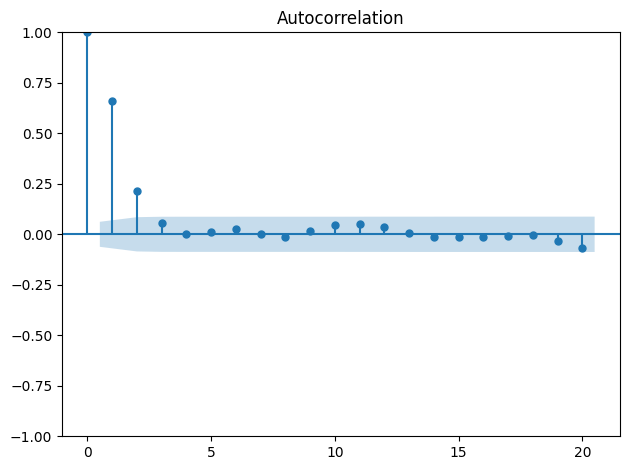

In [4]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

plot_acf(ARMA_1_1, lags=20)
plt.tight_layout()


Notice: the sinusoidal pattern on the plot, meaning that an $\text{AR}(p)$ process is in play. Also, the last significant coefficient is at lag 2, which suggests that $q=2$. However, we know that we simulated a $\text{ARMA}(1,1)$ process, $q=1$. Therefore, the ACF cannot be used to infer the order $q$ of an $\text{ARMA}(p,q)$ process.

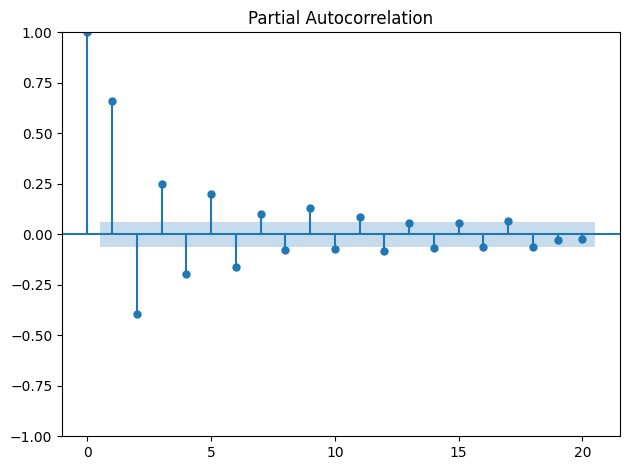

In [5]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(ARMA_1_1, lags=20)
plt.tight_layout()

Similarly: the PACF plot cannot be used to determine the order $p$ of an $\text{ARMA}(p,q)$ process.

The procedure for finding $p$ and $q$ is: list the different values of $p$ and $q$, try and fit every combination of $\text{ARMA}(p,q)$ to the data. Then compute the AIC to quantify the quality of each model in relation to each other, the lowest AIC model is selected. Then analyze the model's residuals; i.e., the difference between the actual and predicted values of the model. Ideally, the residuals would look like white noise (any difference between values can be attributed solely to randomness) which can be tested using a quantile-quantile (Q-Q) plot and running the *Ljung-Box* test. If the analysis leads us to conclude that the residuals are completely random, the model is ready for forecasting.
This process has the additional benefit of applying to non-stationary and stationary series as well.

# AIC
Given that some information is lost a model is fitted to some data, the AIC quantifies how much information is lost.

$$
\text{AIC}=2k-2\ln(\hat{L})
$$

where $k$ is the estimated # of parameters, and $\hat{L}$ is the max value of the likelihood function for the model.

For an $\text{ARMA}(p,q)$ model, $k=p+q$.

The likelihood function is an answer to "how likely is it that my observed data is coming from this model?"

In [6]:
from itertools import product

ps = range(0,4,1)
qs = range(0,4,1)
order_list = list(product(ps, qs))
order_list

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3)]

In [7]:
import pandas as pd
from typing import Union
from tqdm.notebook import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResultsWrapper

def optimize_ARMA(
    endog: Union[pd.Series, list],
    order_list: list, # [(p,q), ...]
) -> pd.DataFrame:
    results = []
    for p, q in tqdm(order_list):
        # presume that the data is stationary
        # so prevent differencing i.e. y_t-y_t-1
        model: SARIMAXResultsWrapper = SARIMAX(endog, order=(p,0,q),
                        simple_differencing=False).fit(disp=False)
        aic: np.ndarray = model.aic
        results.append([(p,q), aic])
    result_df = pd.DataFrame(results, columns=['(p,q)', 'AIC'])
    result_df = (result_df.sort_values(by='AIC', ascending=True)
                 .reset_index(drop=True))
    return result_df

result_df = optimize_ARMA(ARMA_1_1, order_list)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

c:\Users\Ben\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Ben\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Ben\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,"(p,q)",AIC
0,"(1, 1)",2801.407785
1,"(2, 1)",2802.906070
2,"(1, 2)",2802.967762
3,"(0, 3)",2803.666793
4,"(1, 3)",2804.524027
5,"(3, 1)",2804.588567
6,"(2, 2)",2804.822282
7,"(3, 3)",2805.976357
8,"(2, 3)",2806.175380
9,"(3, 2)",2806.894930


# Residual Analysis

AIC gives a measure of relative quality. What we need also is a measure of absolute quality.

Residual analysis basically seeks to answer two questions:
- does the Q-Q plot show a straight line? and
- are the residuals uncorrelated?

E.g.: If the process is a $\text{ARMA}(1,1)$ process e.g. $y_t=\alpha y_{t-1} + \epsilon_t + \beta \epsilon_{t-1}$ fitting our model to it yields $\hat{y_t}=\alpha y_{t-1} + \beta \epsilon_{t-1}$. Thus the residuals is $y_t-\hat{y_t} = \alpha y_{t-1} + \epsilon_t + \beta \epsilon_{t-1} - (\alpha y_{t-1} + \beta \epsilon_{t-1})=\epsilon_t$ so white noise. 

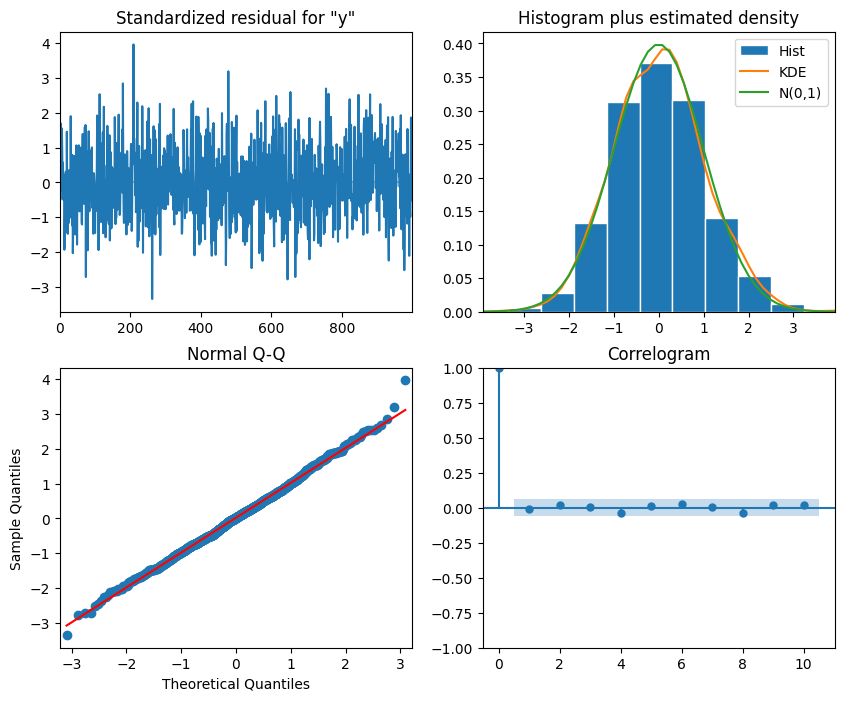

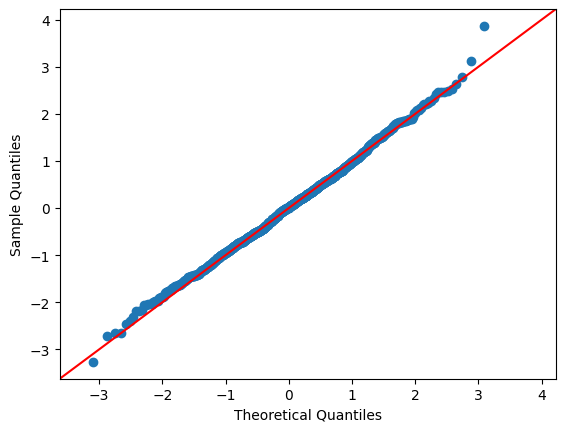

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults
from statsmodels.graphics.gofplots import qqplot

model = SARIMAX(ARMA_1_1, order=(1,0,1), simple_differencing=False)
model_fit: SARIMAXResults = model.fit(disp=False)
model_fit.plot_diagnostics(figsize=(10,8))
residuals: np.ndarray = model_fit.resid

qqplot(residuals, line='45');

- The residuals across the entire dataset appears stationary.
- The residuals have a normal distribution, as indicated by the histogram and Q-Q.
- The autocorrelation has no significant coefficients after lag 0, so they are similar to white noise.

In [9]:
from statsmodels.stats.diagnostic import acorr_ljungbox

df = acorr_ljungbox(residuals, np.arange(1, 11))

print(df['lb_pvalue'].min())
# > 0.005 ==> null hypothesis rejected, no correlation between residuals

0.7210890123080129


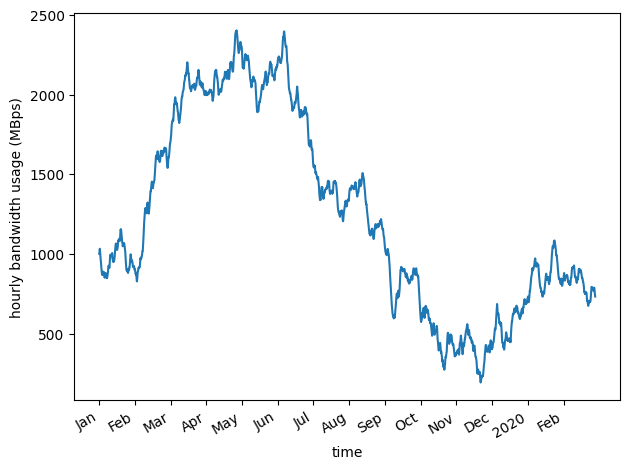

In [10]:
from matplotlib.axes import Axes

df = pd.read_csv('data/bandwidth.csv')
N_POINTS = len(df)

fig, ax = plt.subplots()
ax: Axes

ax.plot(df['hourly_bandwidth'])
ax.set_xlabel('time')
ax.set_ylabel('hourly bandwidth usage (MBps)')

X_LABELS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',
            'Oct', 'Nov', 'Dec', '2020', 'Feb']
ax.set_xticks(np.arange(0, N_POINTS, 30*24), # 1 month ~= 30 days
              X_LABELS)
fig.autofmt_xdate()
fig.tight_layout()

In [11]:
from statsmodels.tsa.stattools import adfuller 

ADF_result = adfuller(df['hourly_bandwidth'])
print(f'ADF Statistic: {ADF_result[0]:.3f}')
print(f'p-value: {ADF_result[1]:.3f}')

ADF Statistic: -0.871
p-value: 0.797


In [12]:
import numpy as np

bandwidth_diff = np.diff(df['hourly_bandwidth'], n=1)

ADF_result = adfuller(bandwidth_diff)
print(f'ADF Statistic: {ADF_result[0]:.3f}')
print(f'p-value: {ADF_result[1]:.3f}')

ADF Statistic: -20.695
p-value: 0.000


In [13]:
df_diff = pd.DataFrame({'bandwidth_diff': bandwidth_diff})
SPLIT = N_POINTS-24*7 # 1 week
train = df_diff.iloc[:SPLIT]
test = df_diff.iloc[SPLIT:]
print(len(train), len(test))

9832 167


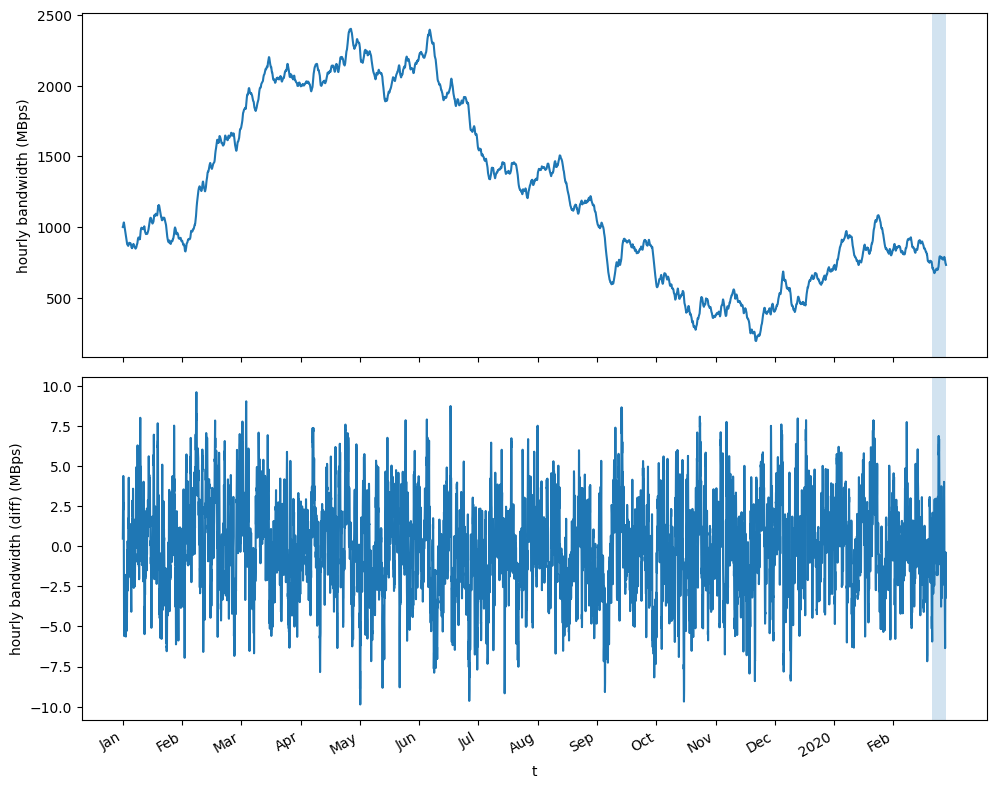

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10,8))
ax1: Axes; ax2: Axes

ax1.plot(df['hourly_bandwidth'])
ax1.set_xlabel('t')
ax1.set_ylabel('hourly bandwidth (MBps)')
ax1.axvspan(SPLIT, N_POINTS, alpha=.2)

ax2.plot(df_diff['bandwidth_diff'])
ax2.set_xlabel('t')
ax2.set_ylabel('hourly bandwidth (diff) (MBps)')
ax2.axvspan(SPLIT, N_POINTS, alpha=.2)

plt.xticks(np.arange(0, N_POINTS, 24*30),
           X_LABELS)

fig.autofmt_xdate()
fig.tight_layout()

In [15]:
ps = range(0,4)
qs = range(0,4)
order_list = list(product(ps, qs))
result_df = optimize_ARMA(train['bandwidth_diff'], order_list)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

c:\Users\Ben\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Ben\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Ben\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,"(p,q)",AIC
0,"(3, 2)",27993.148245
1,"(2, 3)",27993.370625
2,"(2, 2)",27993.681225
3,"(3, 3)",27995.498662
4,"(1, 3)",28005.417553
5,"(1, 2)",28053.393845
6,"(3, 1)",28073.200522
7,"(3, 0)",28097.671822
8,"(2, 1)",28099.304404
9,"(2, 0)",28100.460559


Notice: the AIC for the (2,2) model is very close to the (3,2) and (2,3) models. It is preferred since it is less complex, with $k=4$ instead of $k=5$.

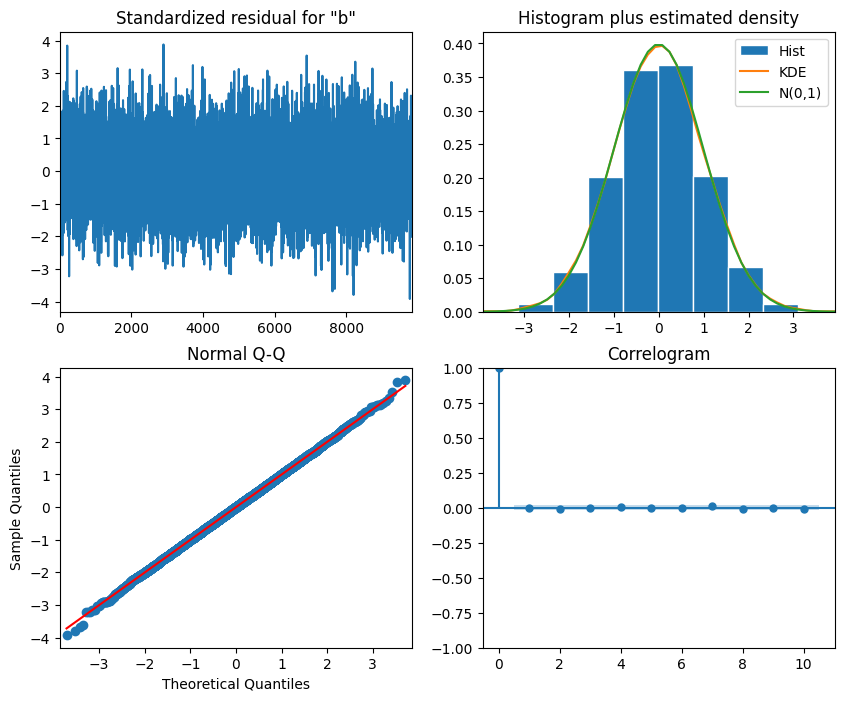

In [16]:
model = SARIMAX(train['bandwidth_diff'], order=(2,0,2), 
                simple_differencing=False)
model_fit = model.fit(disp=False)
model_fit.plot_diagnostics(figsize=(10,8));

In [17]:
residuals = model_fit.resid
ljungbox_df = acorr_ljungbox(residuals, lags=range(1, 11))
ljungbox_df['lb_pvalue'].min()
# > 0.05 ==> no correlation between residuals

0.8115968574371314

In [18]:
from typing import Literal
from statsmodels.tsa.statespace.mlemodel import PredictionResults
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, 
                     window: int, method: Literal['mean', 'last', 'ARMA']):
    if method == 'mean':
        pred_mean = np.empty(horizon)
        for i in range(0, horizon, window):
            mean = np.mean(df[:train_len+i].values)
            pred_mean[i:i+window] = mean
        return pred_mean
    elif method == 'last':
        pred_last = np.empty(horizon)
        for i in range(0, horizon, window):
            last = df[:train_len+i].iloc[-1].values[0]
            pred_last[i:i+window] = last
        return pred_last
    elif method == 'ARMA':
        # let the prediction "window" be i..j (inclusive) 
        # so since i <- 0..horizon-1
        #          j <- window-1..horizon+window-2
        # (sanity check: let window=1
        #  then i <- 0..horizon-1 and
        #       j <- 0..horizon-1 which is identical)
        # so the max value j can have is horizon+window-2
        # thus the array to store the prediction results
        # must have size horizon+window-1;
        pred_ARMA = np.empty(horizon+window-1)
        for i in range(0, horizon, window):
            model = SARIMAX(df[:train_len+i], order=(2,0,2)) # (p,d,q)
            res: SARIMAXResults = model.fit(disp=False)
            # last forecast is inclusive, so -1
            predictions: PredictionResults = res.get_prediction(0, train_len+i+window-1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA[i:i+window] = oos_pred.values
        return pred_ARMA[:horizon]

In [19]:
pred_df = test.copy()
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

test=test.assign(pred_mean=pred_mean, pred_last=pred_last, pred_ARMA=pred_ARMA)

test.head()

,bandwidth_diff,pred_mean,pred_last,pred_ARMA
9832,-5.865194,-0.028816,-5.943995,-5.478227
9833,-3.197066,-0.028816,-5.943995,-4.865435
9834,-1.090197,-0.029732,-3.197066,-2.151610
9835,0.665291,-0.029732,-3.197066,-1.665881
9836,2.081711,-0.029769,0.665291,0.915541


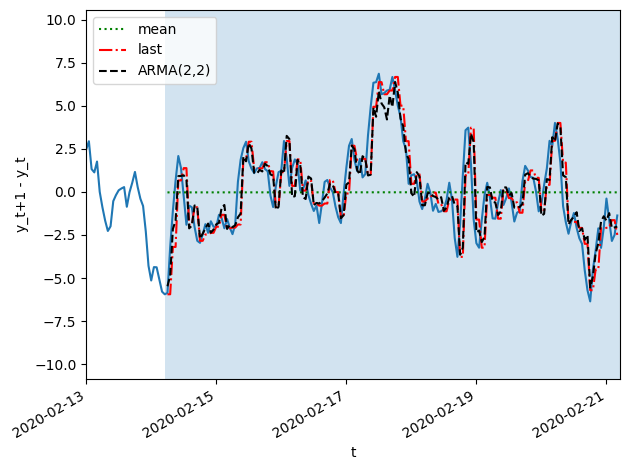

In [20]:
fig, ax = plt.subplots()
ax: Axes

ax.plot(df_diff['bandwidth_diff'])
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last'], 'r-.', label='last')
ax.plot(test['pred_ARMA'], 'k--', label='ARMA(2,2)')
ax.legend(loc=2)
ax.set_xlabel('t')
ax.set_ylabel('y_t+1 - y_t')
ax.axvspan(SPLIT-1, len(df_diff), alpha=.2)
ax.set_xlim(SPLIT-20, len(df_diff))
plt.xticks([9802, 9850, 9898, 9946, 9994],
           ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21'])
fig.autofmt_xdate()
plt.tight_layout()

In [21]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(test['bandwidth_diff'], test['pred_mean'])
mse_last = mean_squared_error(test['bandwidth_diff'], test['pred_last'])
mse_ARMA = mean_squared_error(test['bandwidth_diff'], test['pred_ARMA'])

for mse, label in zip((mse_mean, mse_last, mse_ARMA), ('mean', 'last', 'ARMA(2,2)')):
    print(f'{label}: {mse:.3f}')

mean: 6.135
last: 2.229
ARMA(2,2): 1.716


In [22]:
len(test['pred_ARMA'])
# N_POINTS-1
SPLIT

9832

In [23]:
df['pred_bandwidth'] = pd.Series()
df['pred_bandwidth'][SPLIT+1:] = (
    df['hourly_bandwidth'].iloc[SPLIT+1] +
    test['pred_ARMA'].cumsum()
)
# assert not df['pred_bandwidth'][SPLIT+1:].isna().any()

C:\Users\Ben\AppData\Local\Temp\ipykernel_33836\2281406914.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred_bandwidth'][SPLIT+1:] = (


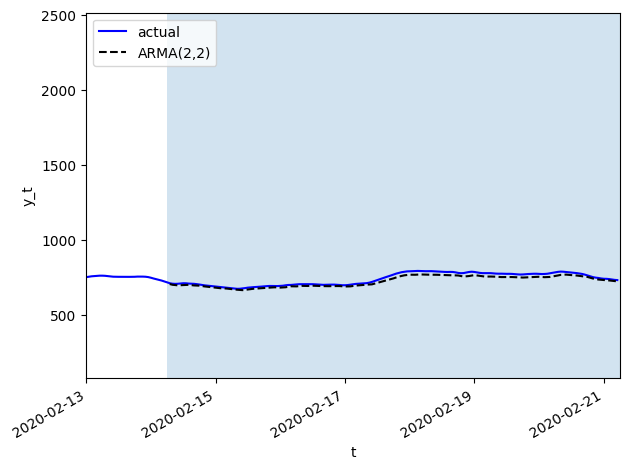

In [24]:
fig, ax = plt.subplots()
ax: Axes

ax.plot(df['hourly_bandwidth'], 'b-', label='actual')
ax.plot(df['pred_bandwidth'], 'k--', label='ARMA(2,2)')

ax.legend(loc=2)

ax.set_xlabel('t')
ax.set_ylabel('y_t')

ax.axvspan(SPLIT, N_POINTS, alpha=.2)
ax.set_xlim(SPLIT-20, N_POINTS)
ax.set_xticks([9802, 9850, 9898, 9946, 9994],
              ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21'])

fig.autofmt_xdate()
fig.tight_layout()

In [25]:
from sklearn.metrics import mean_absolute_error

mae_ARMA_undiff = mean_absolute_error(df['hourly_bandwidth'].iloc[SPLIT+1:],
                                      df['pred_bandwidth'].iloc[SPLIT+1:])
print(mae_ARMA_undiff)

15.274023736496057
